In [30]:
import sys

# Check if running on Google Colab
# If so, mount Google Drive and download CIFAR-10 dataset
if 'google.colab' in sys.modules:
    print("Running on Google Colab")
    # This mounts your Google Drive to the Colab VM.
    from google.colab import drive
    drive.mount('/content/drive')

    # TODO: Enter the foldername in your Drive where you have saved the unzipped
    # assignment folder, e.g. 'cs231n/assignments/assignment1/'
    FOLDERNAME = None
    assert FOLDERNAME is not None, "[!] Enter the foldername."

    # Now that we've mounted your Drive, this ensures that
    # the Python interpreter of the Colab VM can load
    # python files from within it.
    sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))

    # This downloads the CIFAR-10 dataset to your Drive
    # if it doesn't already exist.
    %cd /content/drive/My\ Drive/$FOLDERNAME/cs231n/datasets/
    !bash get_datasets.sh
    %cd /content/drive/My\ Drive/$FOLDERNAME
# END OF COLAB SETUP

# If not running on Google Colab, download CIFAR-10 dataset locally
else:
    print("Not running on Google Colab")
    %cd ./cs231n/datasets/
    !bash get_datasets.sh
    %cd ../..

Not running on Google Colab
/Users/mateo/Library/CloudStorage/OneDrive-MusitelliFilm&Digital/04 - FING/DLVIS/E1/assignment1/cs231n/datasets
/Users/mateo/Library/CloudStorage/OneDrive-MusitelliFilm&Digital/04 - FING/DLVIS/E1/assignment1


# Softmax exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](https://eva.fing.edu.uy/mod/assign/view.php?id=194303) on the course website.*

You will:

- implement a fully-vectorized **loss function** for the Softmax classifier
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** with numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


In [31]:
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [32]:
def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000, num_dev=500):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the linear classifier.
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
    
    # Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
    try:
       del X_train, y_train
       del X_test, y_test
       print('Clear previously loaded data.')
    except:
       pass

    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    mask = np.random.choice(num_training, num_dev, replace=False)
    X_dev = X_train[mask]
    y_dev = y_train[mask]
    
    # Preprocessing: reshape the image data into rows
    X_train = np.reshape(X_train, (X_train.shape[0], -1))
    X_val = np.reshape(X_val, (X_val.shape[0], -1))
    X_test = np.reshape(X_test, (X_test.shape[0], -1))
    X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))
    
    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis = 0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image
    X_dev -= mean_image
    
    # add bias dimension and transform into columns
    X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
    X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
    X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
    X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])
    
    return X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev


# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
print('dev data shape: ', X_dev.shape)
print('dev labels shape: ', y_dev.shape)

Train data shape:  (49000, 3073)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3073)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3073)
Test labels shape:  (1000,)
dev data shape:  (500, 3073)
dev labels shape:  (500,)


## Softmax Classifier

Your code for this section will all be written inside `cs231n/classifiers/softmax.py`.


In [33]:
# First implement the naive softmax loss function with nested loops.
# Open the file cs231n/classifiers/softmax.py and implement the
# softmax_loss_naive function.

from cs231n.classifiers.softmax import softmax_loss_naive
import time

# Generate a random softmax weight matrix and use it to compute the loss.
W = np.random.randn(3073, 10) * 0.0001
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As a rough sanity check, our loss should be something close to -log(0.1).
print('loss: %f' % loss)
print('sanity check: %f' % (-np.log(0.1)))

loss: 2.345232
sanity check: 2.302585


**Inline Question 1**

Why do we expect our loss to be close to -log(0.1)? Explain briefly.**

$\color{blue}{\textit Your Answer:}$ 

$$ \text{loss} = \text{loss} - \log\left( \frac{e^{s_{y_n}}}{\sum e^{s_{y_j}}} \right)$$

10 clases, then probability of belonging to the correct class is $0.1$:

$$ \text{loss} = \log(0.1) $$

This comes out from:

$$\log\left( \frac{e^{s_{y_1}}}{e^{s_{y_1}} + e^{s_{y_2}} + \cdots + e^{s_{y_{10}}}} \right)\overset{e^{s_i}=e^{s_j}}{=}\log(\frac{1}{10}) = \log(0.1)$$

Since the $\text{loss}$ is a summation of 10 equal averaged summands, the final result is:

$$\text{loss} =  \frac{10}{10}\log(\frac{1}{10}) = \log(0.1).$$

In [34]:
# Complete the implementation of softmax_loss_naive and implement a (naive)
# version of the gradient that uses nested loops.
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# Use numeric gradient checking as a debugging tool.
# The numeric gradient should be close to the analytic gradient.
from cs231n.gradient_check import grad_check_sparse
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

# Do another gradient check with regularization
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

numerical: -0.282058 analytic: -0.282057, relative error: 7.037421e-08
numerical: -0.806288 analytic: -0.806288, relative error: 6.368832e-08
numerical: -2.874472 analytic: -2.874472, relative error: 1.909459e-08
numerical: -4.019201 analytic: -4.019201, relative error: 1.107981e-09
numerical: 0.863542 analytic: 0.863542, relative error: 2.454214e-09
numerical: -3.248705 analytic: -3.248705, relative error: 1.686002e-08
numerical: -1.014030 analytic: -1.014030, relative error: 3.618166e-09
numerical: -1.722840 analytic: -1.722840, relative error: 4.291055e-09
numerical: -1.036801 analytic: -1.036801, relative error: 2.986375e-09
numerical: 3.750291 analytic: 3.750291, relative error: 1.795595e-08
numerical: -0.017680 analytic: -0.017680, relative error: 5.097804e-07
numerical: 1.622126 analytic: 1.622125, relative error: 2.291487e-08
numerical: -0.375102 analytic: -0.375102, relative error: 1.270271e-07
numerical: -1.669601 analytic: -1.669601, relative error: 2.763847e-09
numerical: -

In [35]:
# Now that we have a naive implementation of the softmax loss function and its gradient,
# implement a vectorized version in softmax_loss_vectorized.
# The two versions should compute the same results, but the vectorized version should be
# much faster.
tic = time.time()
loss_naive, grad_naive = softmax_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('naive loss: %e computed in %fs' % (loss_naive, toc - tic))

from cs231n.classifiers.softmax import softmax_loss_vectorized
tic = time.time()
loss_vectorized, grad_vectorized = softmax_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# We use the Frobenius norm to compare the two versions
# of the gradient.
grad_difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('Loss difference: %f' % np.abs(loss_naive - loss_vectorized))
print('Gradient difference: %f' % grad_difference)

naive loss: 2.345232e+00 computed in 0.079012s
vectorized loss: 8.564984e+00 computed in 0.011876s
Loss difference: 6.219752
Gradient difference: 0.000000


### Stochastic Gradient Descent

We now have vectorized and efficient expressions for the loss, the gradient and our gradient matches the numerical gradient. We are therefore ready to do SGD to minimize the loss.

In [36]:
# In the file linear_classifier.py, implement SGD in the function
# LinearClassifier.train() and then run it with the code below.
from cs231n.classifiers import Softmax
softmax = Softmax()
tic = time.time()
loss_hist = softmax.train(X_train, y_train, learning_rate=1e-7, reg=2.5e4,
                      num_iters=1500, verbose=True)
toc = time.time()
print('That took %fs' % (toc - tic))

iteration 0 / 1500: loss 793.364682
iteration 100 / 1500: loss 293.693674
iteration 200 / 1500: loss 111.964919
iteration 300 / 1500: loss 45.623217
iteration 400 / 1500: loss 21.439880
iteration 500 / 1500: loss 12.544058
iteration 600 / 1500: loss 9.302659
iteration 700 / 1500: loss 7.996429
iteration 800 / 1500: loss 7.655961
iteration 900 / 1500: loss 7.538992
iteration 1000 / 1500: loss 7.440138
iteration 1100 / 1500: loss 7.446960
iteration 1200 / 1500: loss 7.401809
iteration 1300 / 1500: loss 7.394711
iteration 1400 / 1500: loss 7.375950
That took 6.911730s


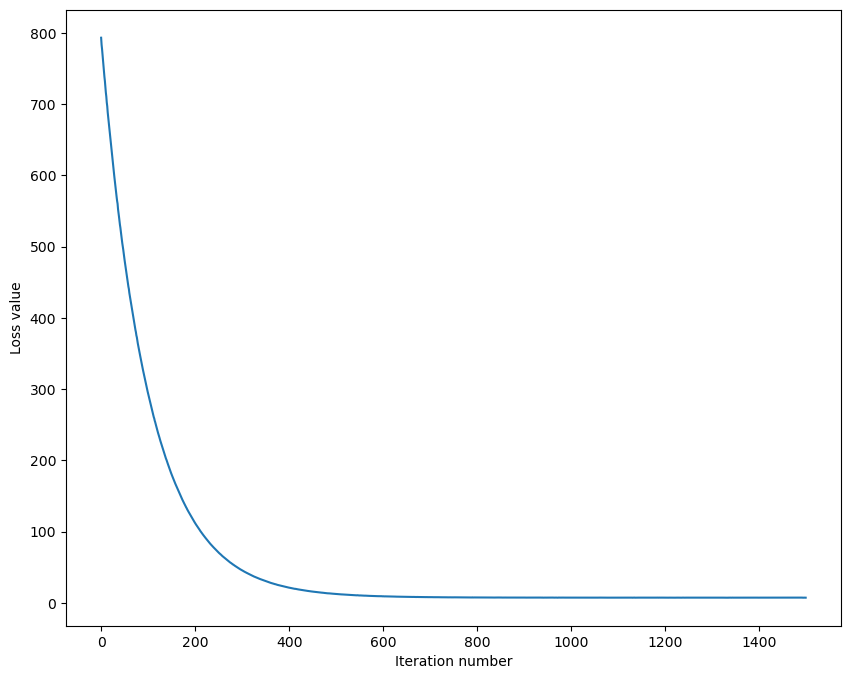

In [37]:
# A useful debugging strategy is to plot the loss as a function of
# iteration number:
plt.plot(loss_hist)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

In [38]:
# Write the LinearClassifier.predict function and evaluate the performance on both the
# training and validation set
y_train_pred = softmax.predict(X_train)
print('training accuracy: %f' % (np.mean(y_train == y_train_pred), ))
y_val_pred = softmax.predict(X_val)
print('validation accuracy: %f' % (np.mean(y_val == y_val_pred), ))

training accuracy: 0.330776
validation accuracy: 0.345000


In [39]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of over 0.35 on the validation set.

from cs231n.classifiers import Softmax
results = {}
best_val = -1
best_softmax = None

################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# Save the best trained softmax classifer in best_softmax.                          #
################################################################################

# Provided as a reference. You may or may not want to change these hyperparameters
learning_rates = [1e-3, 5e-3, 1e-5, 5e-5, 1e-7, 5e-7, 1e-9, 5e-9, 1e-10, 5e-10, 1e-12, 5e-12]
regularization_strengths = [10, 50, 1e2, 2e2, 1e3, 5e3, 2.5e4, 5e4, 1e6, 2e6]

# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

# All-for-all GridSearch
for lr in learning_rates:
    for rs in regularization_strengths:

        # Initialize classifier
        softmax = Softmax()
        # Train
        loss_hist = softmax.train(X_train, y_train, learning_rate=lr, reg=rs, num_iters=1500, verbose=False)
        # Evaluate on train
        y_train_pred = softmax.predict(X_train)
        # Evaluate on validation
        y_val_pred = softmax.predict(X_val)
        
        # Accuracies
        train_acc = np.mean(y_train == y_train_pred)
        val_acc = np.mean(y_val == y_val_pred)

        # Update dictionary (train, val)
        results[(lr,rs)] = (train_acc, val_acc)

        # Compare with previous parameters
        if val_acc > best_val:
            # If accuracy increases, update the best result and the classifier
            best_val = val_acc
            best_softmax = softmax

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

/Users/mateo/Library/CloudStorage/OneDrive-MusitelliFilm&Digital/04 - FING/DLVIS/E1/assignment1/cs231n/classifiers/softmax.py:99: RuntimeWarning: divide by zero encountered in log
  # Init. matrix to be the ones matrix (shape = N, C)
/Users/mateo/Library/CloudStorage/OneDrive-MusitelliFilm&Digital/04 - FING/DLVIS/E1/assignment1/cs231n/classifiers/softmax.py:104: RuntimeWarning: invalid value encountered in divide
  


lr 1.000000e-12 reg 1.000000e+01 train accuracy: 0.134122 val accuracy: 0.124000
lr 1.000000e-12 reg 5.000000e+01 train accuracy: 0.082735 val accuracy: 0.081000
lr 1.000000e-12 reg 1.000000e+02 train accuracy: 0.082816 val accuracy: 0.080000
lr 1.000000e-12 reg 2.000000e+02 train accuracy: 0.098469 val accuracy: 0.099000
lr 1.000000e-12 reg 1.000000e+03 train accuracy: 0.106918 val accuracy: 0.086000
lr 1.000000e-12 reg 5.000000e+03 train accuracy: 0.109122 val accuracy: 0.097000
lr 1.000000e-12 reg 2.500000e+04 train accuracy: 0.131286 val accuracy: 0.117000
lr 1.000000e-12 reg 5.000000e+04 train accuracy: 0.127939 val accuracy: 0.114000
lr 1.000000e-12 reg 1.000000e+06 train accuracy: 0.107633 val accuracy: 0.126000
lr 1.000000e-12 reg 2.000000e+06 train accuracy: 0.128898 val accuracy: 0.125000
lr 5.000000e-12 reg 1.000000e+01 train accuracy: 0.101980 val accuracy: 0.103000
lr 5.000000e-12 reg 5.000000e+01 train accuracy: 0.102388 val accuracy: 0.110000
lr 5.000000e-12 reg 1.000000

In [40]:
# evaluate on test set
# Evaluate the best softmax on test set
y_test_pred = best_softmax.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('softmax on raw pixels final test set accuracy: %f' % (test_accuracy, ))

softmax on raw pixels final test set accuracy: 0.372000


**Inline Question 2** - *Softmax loss with Temperature*

Suppose we want to use a temperature parameter $T$ for the softmax distribution: 
$$P(i) = \frac{e^{\frac{f_i}{T}}}{\sum_j e^{\frac{f_j}{T}}} $$
where $f_i$ is the score for class $i$
- What values of $T$ would make the model more confident about its predictions?

$\color{blue}{\textit Your Answer:}$

Recall that when $T=1$ the result is the old an beloved Softmax. When $T<1$, the expression becomes closer to the *step function*, enhancing the confidence by reducing the threshold area. The opposit occurs when $T>1$, since the thresold area becomes even smoother.

The four graphs below illustrate the aforementioned behavior. For $T = 0.1$ and $T = 0.2$, the functions closely resemble the *step function*. Then, $T = 1$ is included to facilitate comparison. Finally, $T = 2$ demonstrates that the threshold region becomes even smoother than with $T = 1$.



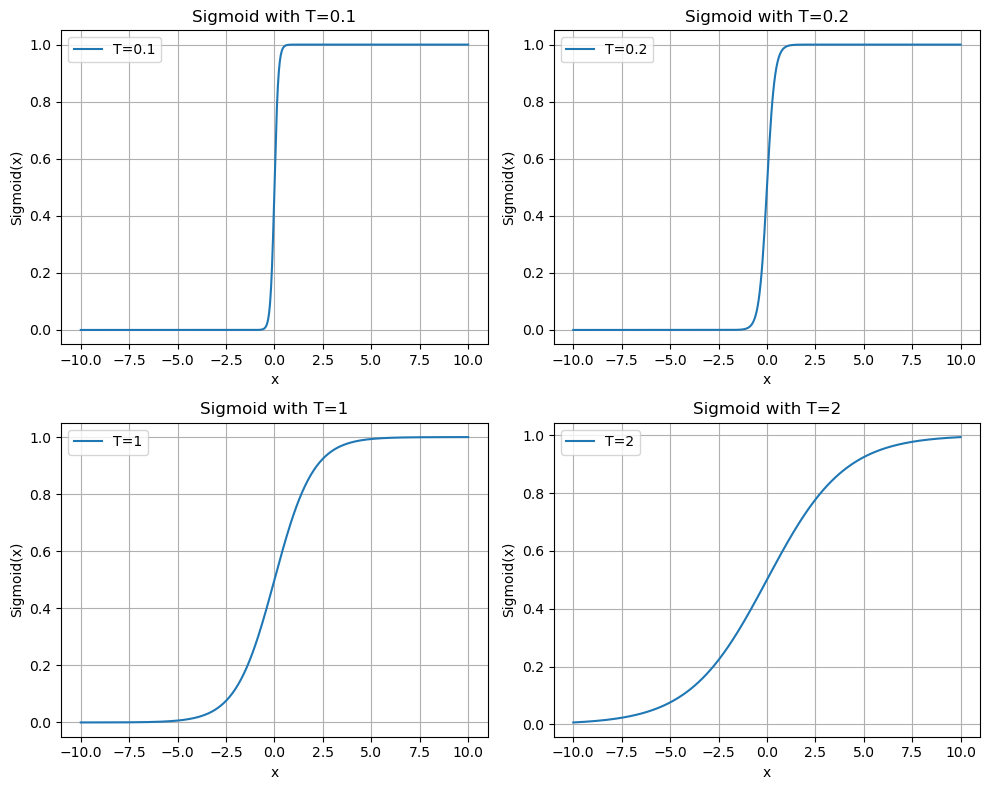

In [7]:
# Sigmoid function with temperature scaling
def sigmoid(x, T):
    return 1 / (1 + np.exp(-x / T))

# Generate values for x
x = np.linspace(-10, 10, 400)

# Different temperature values
temperatures = [0.1, 0.2, 1, 2]

# Create subplots for each temperature
fig, axes = plt.subplots(2, 2, figsize=(10, 8))

# Flatten the axes array for easier iteration
axes = axes.flatten()

# Plot each sigmoid function in a separate subplot
for i, T in enumerate(temperatures):
    y = sigmoid(x, T)
    axes[i].plot(x, y, label=f'T={T}')
    axes[i].set_title(f'Sigmoid with T={T}')
    axes[i].set_xlabel('x')
    axes[i].set_ylabel('Sigmoid(x)')
    axes[i].legend()
    axes[i].grid(True)

# Adjust layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()


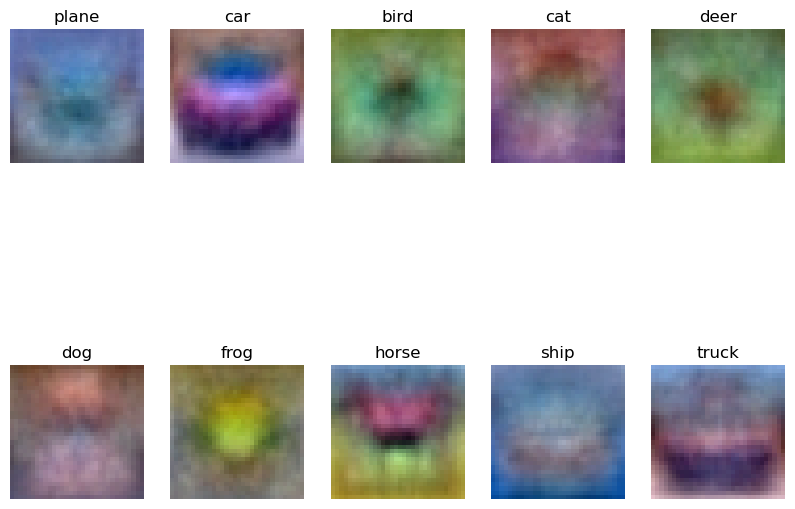

In [41]:
# Visualize the learned weights for each class
w = best_softmax.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)

w_min, w_max = np.min(w), np.max(w)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)
    
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])